In [2]:
# Imports
import os
import random
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from torchvision import models
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision.transforms import functional as TF
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns
from torch.optim.lr_scheduler import CosineAnnealingLR
import zipfile


In [3]:

# Step 1: Mount Google Drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)
# Step 2: Define paths (edit these if needed)
zip_path = "/content/drive/MyDrive/dataset_V6.zip"  # <-- change this if your file is in a folder
extract_dir = "/content/dataset_V6"

# Step 3: Unzip the dataset

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Extracted dataset to: {extract_dir}")




# Step 4 (Optional): Copy the CSV if it's also on Drive
# If your CSV is in MyDrive, adjust the path accordingly

csv_drive_path = "/content/drive/MyDrive/dataset_V6.csv"
csv_colab_path = "/content/dataset_V6.csv"

!cp "{csv_drive_path}" "{csv_colab_path}"

print(f"✅ CSV copied to: {csv_colab_path}")




MessageError: Error: credential propagation was unsuccessful

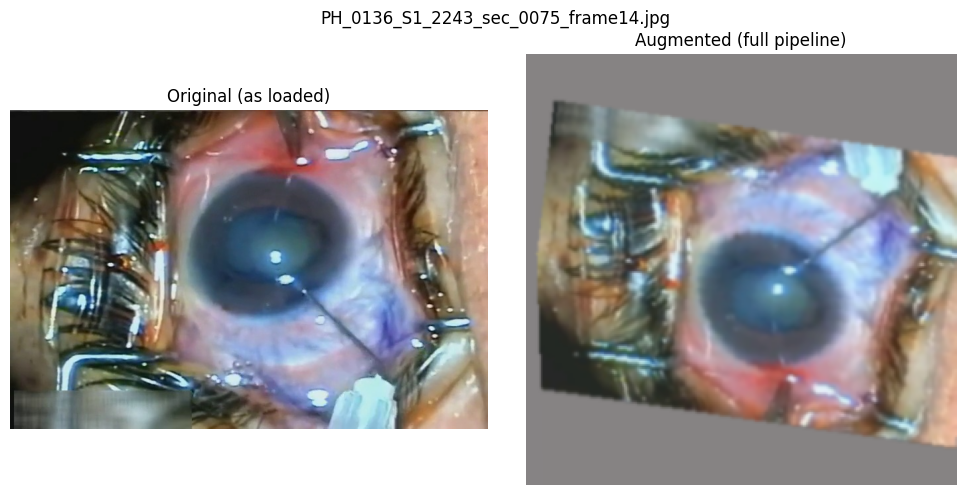

In [12]:
# --- Colab cell: visualize a random augmentation (side-by-side) ---

import os, glob, random
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

# ---------- Config (use your variables) ----------
CSV_PATH = "dataset_V6.csv"
IMAGE_DIR = "/content/dataset_V6/dataset_V6"  # folder that contains your images

# ---------- Utils ----------
def _mean_rgb(image: Image.Image):
    arr = np.array(image.convert("RGB"))
    return tuple(arr.reshape(-1, 3).mean(axis=0).astype(np.uint8).tolist())

class PadToSquareWithMean:
    def __call__(self, image: Image.Image):
        w, h = image.size
        max_dim = max(w, h)
        pad_left  = (max_dim - w) // 2
        pad_top   = (max_dim - h) // 2
        pad_right = max_dim - w - pad_left
        pad_bottom= max_dim - h - pad_top
        mean_color = _mean_rgb(image)
        return TF.pad(image, (pad_left, pad_top, pad_right, pad_bottom),
                      fill=mean_color, padding_mode='constant')

class RotateWithMeanFill:
    def __init__(self, degrees=12):
        self.degrees = degrees
    def __call__(self, image: Image.Image):
        angle = transforms.RandomRotation.get_params([-self.degrees, self.degrees])
        mean_color = _mean_rgb(image)
        return TF.rotate(image, angle=angle, expand=False, fill=mean_color)

class AffineWithMeanFill:
    """
    Mild translation/scale/shear with mean-color fill.
    """
    def __init__(self, degrees=0, translate=(0.08, 0.08), scale=(0.95, 1.05), shear=(-5, 5)):
        self.degrees = degrees
        self.translate = translate
        self.scale = scale
        self.shear = shear

    def __call__(self, image: Image.Image):
        angle, translations, scale, shear = transforms.RandomAffine.get_params(
            degrees=(-self.degrees, self.degrees),
            translate=self.translate,
            scale_ranges=self.scale,
            shears=self.shear,
            img_size=image.size
        )
        mean_color = _mean_rgb(image)
        return TF.affine(
            image,
            angle=angle,
            translate=translations,
            scale=scale,
            shear=shear,
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=mean_color
        )

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# ---------- Your exact pipelines ----------
base_transform = transforms.Compose([
    PadToSquareWithMean(),
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

aug_transform = transforms.Compose([
    PadToSquareWithMean(),
    transforms.Resize((260, 260)),

    # Geometry
    RotateWithMeanFill(degrees=12),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.1),
    AffineWithMeanFill(
        degrees=0,
        translate=(0.10, 0.10),
        scale=(0.95, 1.05),
        shear=(-4, 4)
    ),

    # Photometric
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.10)
    ], p=0.6),

    # Light blur
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 1.2))
    ], p=0.3),

    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# ---------- Helper: denormalize a CHW tensor back to PIL for display ----------
def denorm_to_pil(t: torch.Tensor) -> Image.Image:
    if t.ndim == 3:
        mean = torch.tensor(IMAGENET_MEAN, dtype=t.dtype, device=t.device)[:, None, None]
        std  = torch.tensor(IMAGENET_STD,  dtype=t.dtype, device=t.device)[:, None, None]
        x = t * std + mean
        x = x.clamp(0, 1)
        return transforms.ToPILImage()(x.cpu())
    else:
        raise ValueError("Expected CHW tensor")

# ---------- Find a random image ----------
def find_all_images(root):
    exts = ("*.png", "*.jpg", "*.jpeg", "*.bmp", "*.tif", "*.tiff", "*.webp")
    files = []
    for e in exts:
        files.extend(glob.glob(os.path.join(root, "**", e), recursive=True))
    return files

all_imgs = find_all_images(IMAGE_DIR)
assert len(all_imgs) > 0, f"No images found under {IMAGE_DIR}"
img_path = random.choice(all_imgs)

# ---------- Load, augment, visualize ----------
orig = Image.open(img_path).convert("RGB")
aug_t = aug_transform(orig)         # apply your full augmentation pipeline
aug_img = denorm_to_pil(aug_t)      # back to PIL for viewing

# Optionally, to make sizes match visually (left = raw, right = augmented):
# show the raw original (unmodified) vs augmented. If you prefer, resize only for display:
disp_orig = orig

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(disp_orig)
plt.title("Original (as loaded)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(aug_img)
plt.title("Augmented (full pipeline)")
plt.axis("off")

plt.suptitle(os.path.basename(img_path))
plt.tight_layout()
plt.show()
